# Linear regression for causal treatment effects

Quick exploration into regression coefficients in the presence of confounders and colliders.

Outline:
*   Generate random linear data
*   Estimate treatment effects with regression models
*   Repeat in the presence on confounder variables
*   Repeat in the presence on collider variables

In [1]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
from IPython.display import Image, display

## Simple data generating case

For the first simple case we have no confounding variables and no collider variables.

In [2]:
n_samples = 1000
n_features = 3
treatment_binary = True

rand = np.random.default_rng(0)
x = rand.normal(loc=rand.normal(size=n_features), size=(n_samples, n_features))
if treatment_binary:
    t = rand.binomial(n=1, p=0.5, size=(n_samples, 1))
else:
    t = rand.normal(size=(n_samples, 1))
bias = rand.normal()
weights = rand.normal(size=(n_features + 1, 1))
y = bias + np.dot(np.concatenate([t, x], axis=1), weights) + rand.normal()

x_cols = [f"x_{idx+1}" for idx in range(3)]
t_col = "t"
y_col = "y"
df = pd.DataFrame(x, columns=x_cols)
df[t_col] = t
df[y_col] = y
df = df[[y_col, t_col] + x_cols]

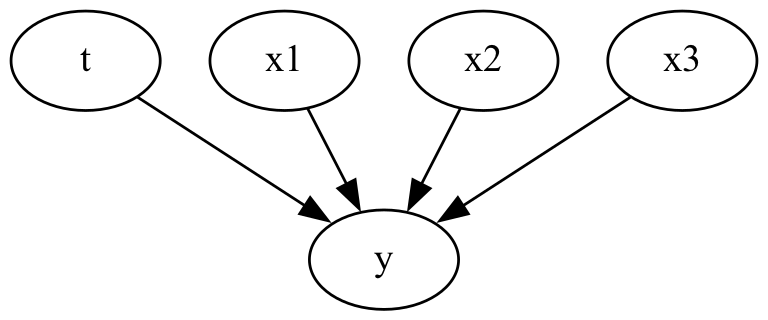

In [4]:
causal_graph = """
digraph {
    t -> y;
    x1 -> y;
    x2 -> y;
    x3 -> y;
}
"""

model = CausalModel(
    data=df, graph=causal_graph.replace("\n", " "), treatment=t_col, outcome=y_col
)
model.view_model()
display(Image(filename="causal_model.png"))

Fitting a linear regression model will let us estimate the coefficients and therefore treatment effect.
We can do this adding one feature at a time to see how the extra features change the coefficients of the treatment effect.

In [4]:
# fit linear regression with adding a feature at a time
import sklearn.linear_model

fitted_bias = []
fitted_coef = []
for idx in range(n_features + 1):
    model = sklearn.linear_model.LinearRegression()
    model.fit(df[[t_col] + x_cols[:idx]], df[y_col])
    fitted_bias.append(model.intercept_)
    fitted_coef.append(model.coef_)

print("\n")
print("True weights:")
print(bias, weights)


df_coef = pd.DataFrame(fitted_coef, columns=[t_col] + x_cols)
df_coef["bias"] = fitted_bias
df_coef



True weights:
2.0066816575193047 [[ 1.64781487]
 [-0.30894266]
 [-1.6550682 ]
 [-1.02182841]]


,t,x_1,x_2,x_3,bias
0,1.519434,NaN,NaN,NaN,1.408745
1,1.529226,-0.282864,NaN,NaN,1.410615
2,1.660679,-0.300862,-1.637047,NaN,1.176271
3,1.647815,-0.308943,-1.655068,-1.021828,1.803989


We dont see a big change in the treatment coefficient and it converges to the correct treatment effect. If we have no confounders or collider variables, we can reasonably estimate the treatment effect without including those variables in the linear regression model.

## Confounding variables

Now we insert a confounding variable in to the mix. Here, `x2` can influence the treatment as well as the outcome.

In [5]:
n_samples = 1000
n_features = 3
treatment_binary = True

rand = np.random.default_rng(0)
x = rand.normal(loc=rand.normal(size=n_features), size=(n_samples, n_features))


def logit(p):
    return np.log(p) - np.log(1 - p)


def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))


# confound t with x_2
if treatment_binary:
    t = rand.binomial(n=1, p=inv_logit(x[:, [1]]), size=(n_samples, 1))
else:
    t = rand.normal(size=(n_samples, 1)) + x[:, [1]]
bias = rand.normal()
weights = rand.normal(size=(n_features + 1, 1))
y = bias + np.dot(np.concatenate([t, x], axis=1), weights) + rand.normal()

x_cols = [f"x_{idx+1}" for idx in range(3)]
t_col = "t"
y_col = "y"
df = pd.DataFrame(x, columns=x_cols)
df[t_col] = t
df[y_col] = y
df = df[[y_col, t_col] + x_cols]

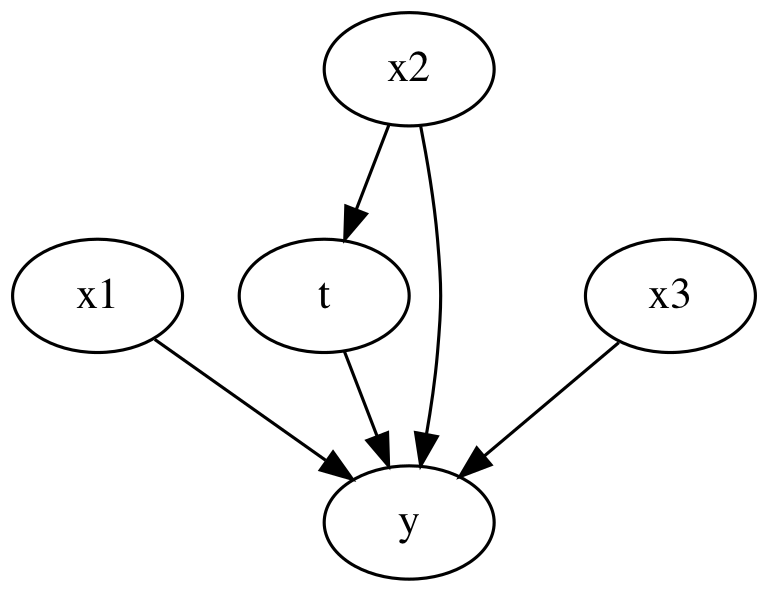

In [6]:
causal_graph = """
digraph {
    t -> y;
    x1 -> y;
    x2 -> y;
    x3 -> y;
    x2 -> t;
}
"""

model = CausalModel(
    data=df, graph=causal_graph.replace("\n", " "), treatment=t_col, outcome=y_col
)
model.view_model()
display(Image(filename="causal_model.png"))

In [7]:
# fit linear regression with adding a feature at a time
import sklearn.linear_model

fitted_bias = []
fitted_coef = []
for idx in range(n_features + 1):
    model = sklearn.linear_model.LinearRegression()
    model.fit(df[[t_col] + x_cols[:idx]], df[y_col])
    fitted_bias.append(model.intercept_)
    fitted_coef.append(model.coef_)

print("\n")
print("True weights:")
print(bias, weights)


df_coef = pd.DataFrame(fitted_coef, columns=[t_col] + x_cols)
df_coef["bias"] = fitted_bias
df_coef



True weights:
2.0066816575193047 [[ 1.64781487]
 [-0.30894266]
 [-1.6550682 ]
 [-1.02182841]]


,t,x_1,x_2,x_3,bias
0,0.347971,NaN,NaN,NaN,1.982377
1,0.358052,-0.271728,NaN,NaN,1.983870
2,1.675090,-0.301064,-1.642632,NaN,1.168674
3,1.647815,-0.308943,-1.655068,-1.021828,1.803989


The coefficient for the treatment is biased until we include `x_2`. This illustrates how running a regression to estimate an average treatment effect is incorrect if we don't include the confounding variables.

## Collider variables

Now we insert a collider variable in to the mix. `x3` doesn't influence the treatment or the outcome.

In [8]:
n_samples = 1000
n_features = 3
treatment_binary = True

rand = np.random.default_rng(0)
x = rand.normal(loc=rand.normal(size=n_features), size=(n_samples, n_features))


if treatment_binary:
    t = rand.binomial(n=1, p=0.5, size=(n_samples, 1))
else:
    t = rand.normal(size=(n_samples, 1))
bias = rand.normal()
weights = rand.normal(size=(n_features + 1, 1))
y = bias + np.dot(np.concatenate([t, x], axis=1), weights) + rand.normal()
# collider variable
x[:, [2]] = y + 0.2 * t + 2 * rand.normal(size=(n_samples, 1))

x_cols = [f"x_{idx+1}" for idx in range(3)]
t_col = "t"
y_col = "y"
df = pd.DataFrame(x, columns=x_cols)
df[t_col] = t
df[y_col] = y
df = df[[y_col, t_col] + x_cols]

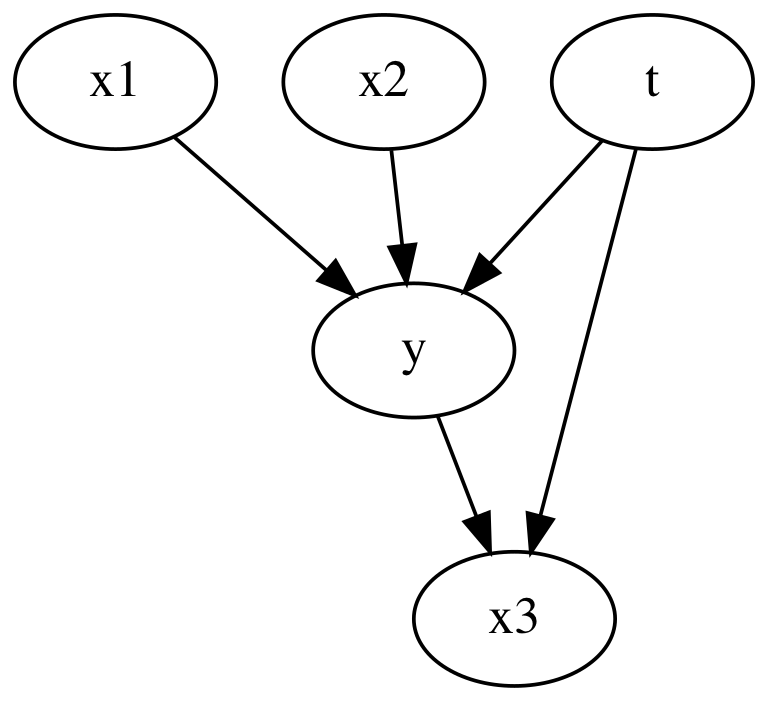

In [9]:
causal_graph = """
digraph {
    t -> y;
    x1 -> y;
    x2 -> y;
    t -> x3;
    y -> x3;
}
"""

model = CausalModel(
    data=df, graph=causal_graph.replace("\n", " "), treatment=t_col, outcome=y_col
)
model.view_model()
display(Image(filename="causal_model.png"))

In [10]:
# fit linear regression with adding a feature at a time
import sklearn.linear_model

fitted_bias = []
fitted_coef = []
for idx in range(n_features + 1):
    model = sklearn.linear_model.LinearRegression()
    model.fit(df[[t_col] + x_cols[:idx]], df[y_col])
    fitted_bias.append(model.intercept_)
    fitted_coef.append(model.coef_)

print("\n")
print("True weights:")
print(bias, weights)


df_coef = pd.DataFrame(fitted_coef, columns=[t_col] + x_cols)
df_coef["bias"] = fitted_bias
df_coef



True weights:
2.0066816575193047 [[ 1.64781487]
 [-0.30894266]
 [-1.6550682 ]
 [-1.02182841]]


,t,x_1,x_2,x_3,bias
0,1.519434,NaN,NaN,NaN,1.408745
1,1.529226,-0.282864,NaN,NaN,1.410615
2,1.660679,-0.300862,-1.637047,NaN,1.176271
3,1.258854,-0.238477,-1.278788,0.217041,0.902449


Here we see when we include `x_3`, the collider variable, we can a biased coefficient for the treatment. This shows how including variables which are caused by the treatment and the outcome will cause incorrect estimations of average treatment effects.

## Conclusion

Make sure you add the confounders, but not the colliders!